In [1]:
suppressWarnings(suppressMessages(library(tidyverse))) #ggplot and dplyr
suppressWarnings(suppressMessages(library(reshape2))) #melt
suppressWarnings(suppressMessages(require(gridExtra))) #Aggregate plots
suppressWarnings(suppressMessages(library(caret))) #evaluation metrics (such as confusion matrix)
suppressWarnings(suppressMessages(library(glmnet))) #ridge and lasso
suppressWarnings(suppressMessages(library(MASS))) #LDA QDA
suppressWarnings(suppressMessages(library(fastDummies))) #something like pd.dummies()
suppressWarnings(suppressMessages(library(InformationValue))) #evaluation metrics (ROC / AUC / Concordance) nao resultou, deu valores errados
suppressWarnings(suppressMessages(library(scales))) #scales for plots
suppressWarnings(suppressMessages(library(ROCR))) #Calculate and plot ROC curves and AUC

# UCI Heart Disease Dataset - Classification

Authors:
* Vasco Campos -> up201908482
* Bruno Reis -> up201908682

In this notebook, we will test several methods of classification to predict if a pacient has a heart disease or not. The different methods tested are:
* Logistic Regression.
* LDA, Linear Discriminant Analysis.
* QDA, Quadratic Discriminant Analysis.
* KNN, K-Nearest Neighbors.

The target variable is named **target** and has two different values:
* 1 for people with heart disease.
* 0 for people with no heart disease.

Also in this notebook, not only will we compare the accuracy of every different approach, as well as how certain parameters can affect this accuracy (in the case of the KNN algorithm, for example), but we will also compare the effectiveness of feature selection in the accuracy of each model.

To understand the effects of feature selection, we will have a model that only uses variables whose coefficients in the lasso method were **higher than 0** and another model that uses all the variables in the dataset. For each method both of this datasets will be used and its results will be compared.

Taking everything else into account, the notebook follows the proceeding structure:
1. Applying Feature Selection
2. Logistic Regression
    * Complete model
    * Reduced model
    * Comparison and conclusion
3. Linear Discriminant Analysis
    * Complete model
    * Reduced model
    * Comparison and conclusion
4. Quadratic Discrimant Analysis
    * Complete model
    * Reduced model
    * Comparison and conclusion
5. K-Nearest Neighbors
    * Complete model
        * Parameter tuning
    * Reduced model
        * Parameter tuning
    * Comparison and conclusion
6. Final Conclusions
    * Comparing models
    * Comparing feature selections
    * Tuning Parameters
    

# Applying Feature Selection
In this section both the complete dataset and the feature selected dataset and presented and compared.

## Complete Dataset
The complete dataset is shown just as described in previous notebooks.

It consists of **13** predictor variables, most a lot of those being *factors* and **1** target variable named **target**. It is relevant to mention if each factor category was treated as a variable (which happens when we fit the models in the next parts of the notebook), the dataset actually consists of **31** variables.

In [3]:
uci_heart = read_csv("C:/Users/HP/Desktop/mestrado/2semestre/EstatisticaEAnaliseDeDados/EADProject/heart.csv", col_types = c("nffnnffnfdffff"))

#remove wrong thal values
uci_heart = uci_heart[uci_heart$thal != 0, ]

uci_heart$thal = droplevels(uci_heart$thal, exclude = "0")

uci_heart$target = relevel(uci_heart$target, "0")
uci_heart$cp = relevel(uci_heart$cp, "1")

summary(uci_heart)
dim(uci_heart)

      age        sex     cp         trestbps          chol       fbs    
 Min.   :29.00   1:206   1: 50   Min.   : 94.0   Min.   :126.0   1: 44  
 1st Qu.:47.00   0: 95   3: 23   1st Qu.:120.0   1st Qu.:211.0   0:257  
 Median :56.00           2: 86   Median :130.0   Median :241.0          
 Mean   :54.38           0:142   Mean   :131.6   Mean   :246.5          
 3rd Qu.:61.00                   3rd Qu.:140.0   3rd Qu.:275.0          
 Max.   :77.00                   Max.   :200.0   Max.   :564.0          
 restecg    thalach      exang      oldpeak      slope   ca      thal   
 0:146   Min.   : 71.0   0:203   Min.   :0.000   0: 21   0:173   1: 18  
 1:151   1st Qu.:134.0   1: 98   1st Qu.:0.000   2:141   2: 38   2:166  
 2:  4   Median :153.0           Median :0.800   1:139   1: 65   3:117  
         Mean   :149.7           Mean   :1.043           3: 20          
         3rd Qu.:166.0           3rd Qu.:1.600           4:  5          
         Max.   :202.0           Max.   :6.200     

[1] 301  14

## Feature Selection Dataset
As explained before, the feature selection was performed using the **lasso** method, in which any variable whose coefficient turned out to be **0** was removed from the model.

Taking this into consideration, the factor variables of the dataset were split by category and the ones with coefficients equal to 0 (check feature selection notebook) were removed from the dataset. This left the dataset with only **17** variables out of a total **31** variables.

As we can see, the feature selection dataset will make the models training a lot **easier to interpret**, due to the fact that the amount of variables is reduced drastically, but it can cause **loss of information**, due to the variables that are not fitting in the model.

22 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) -0.148960532
age          .          
sex0         0.367035877
cp3          .          
cp2          .          
cp0         -1.052030530
trestbps     .          
chol         .          
fbs0         .          
restecg1     0.048187974
restecg2     .          
thalach      0.008621257
exang1      -0.375605735
oldpeak     -0.256756615
slope2       0.175310696
slope1      -0.222576373
ca2         -0.930336579
ca1         -0.747344998
ca3         -0.515315377
ca4          .          
thal2        0.633914633
thal3       -0.505268424

[1] 301  40

      age        sex        thalach      exang      oldpeak      target 
 Min.   :29.00   1:206   Min.   : 71.0   0:203   Min.   :0.000   0:137  
 1st Qu.:47.00   0: 95   1st Qu.:134.0   1: 98   1st Qu.:0.000   1:164  
 Median :56.00           Median :153.0           Median :0.800          
 Mean   :54.38           Mean   :149.7           Mean   :1.043          
 3rd Qu.:61.00           3rd Qu.:166.0           3rd Qu.:1.600          
 Max.   :77.00           Max.   :202.0           Max.   :6.200          
 cp_1    cp_0    fbs_1   restecg_0 restecg_1 slope_0 slope_1 ca_0    ca_1   
 0:251   0:159   0:257   0:155     0:150     0:280   0:162   0:128   0:236  
 1: 50   1:142   1: 44   1:146     1:151     1: 21   1:139   1:173   1: 65  
                                                                            
                                                                            
                                                                            
                           

[1] 301  17

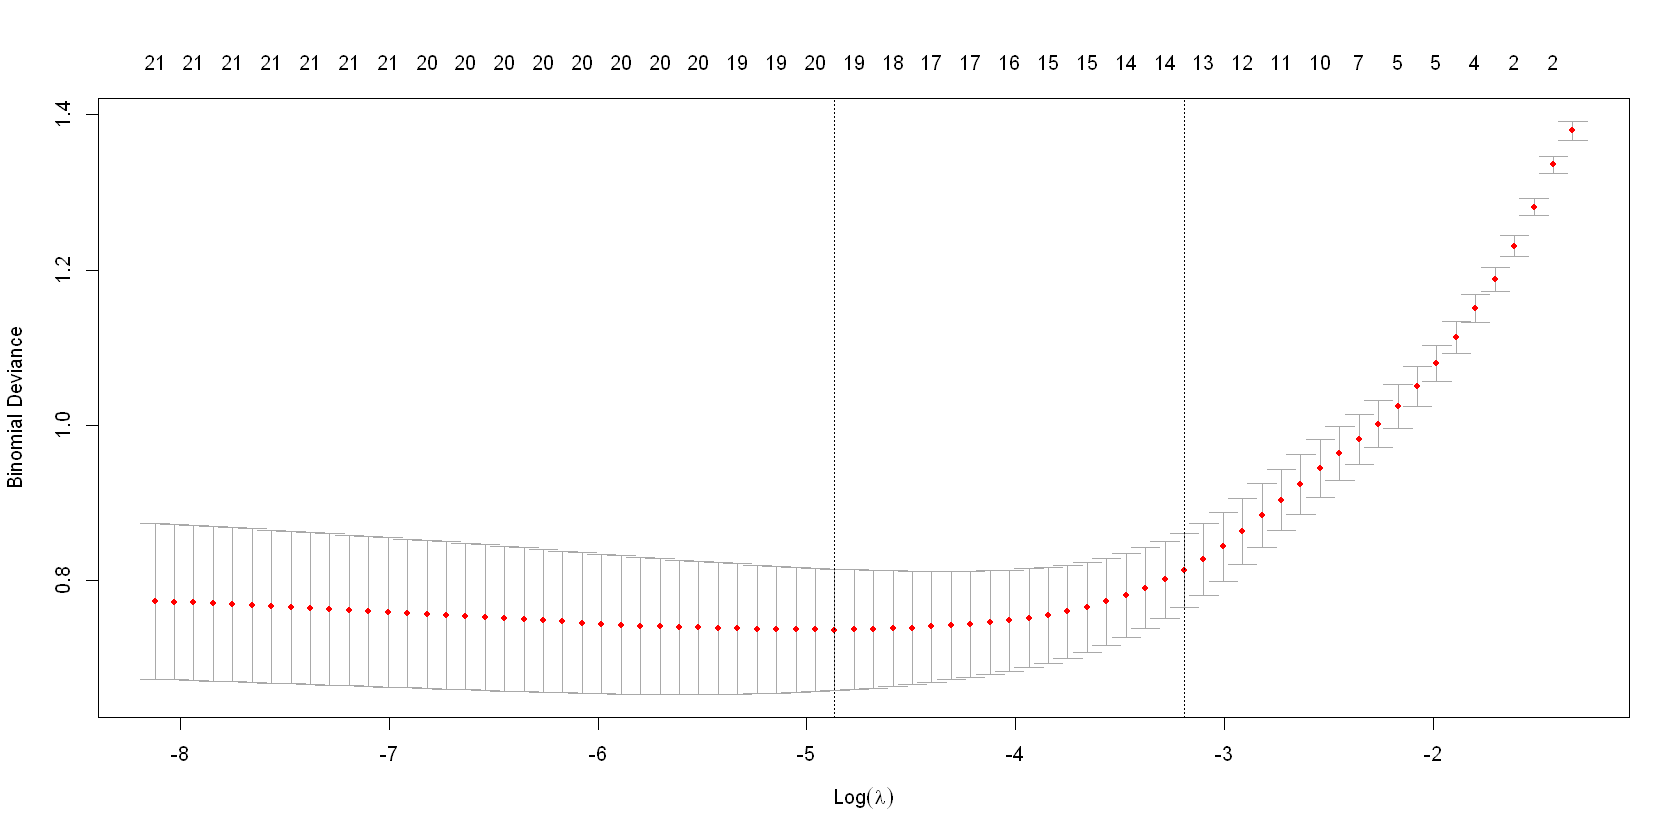

In [19]:
#df.reduced = dummy_cols(uci_heart, remove_first_dummy = TRUE) #Se o fator so tem dois niveis nao faz sentido ser incluido nos dummies (so vai causar redundancia)

cv.lasso = cv.glmnet(model.matrix(target ~ ., data = uci_heart)[, -1], uci_heart$target, alpha = 1, family = "binomial", nfolds = 10) #fazer com o train set
plot(cv.lasso)

#best.lambda = cv.lasso$lambda.min
#best.lambda

#coef(cv.lasso)
#coef(cv.lasso, best.lambda)
coef(cv.lasso, cv.lasso$lambda.1se) #The coefficients with this lambda are 0 when they are not relevant.




df.reduced = dummy_cols(uci_heart)

#summary(df.reduced)
dim(df.reduced)

#df.reduced = df.reduced[, !(names(df.reduced) %in% 
#        c("cp", "trestbps", "chol", "fbs", "restecg", "slope", "ca", "thal", "sex_0", "cp_3", "cp_2", "fbs_0", "restecg_2", "exang_1", "slope_2", "ca_2", "ca_3", "ca_4", "thal_3", "target_1"))]

df.reduced = df.reduced[, !(names(df.reduced) %in% 
        c("cp", "trestbps", "chol", "fbs", "restecg", "slope", "ca", "thal", "sex_0", "sex_1", "cp_3", "cp_2", "fbs_0", "restecg_2", "exang_0", "exang_1", "slope_2", "ca_2", "ca_3", "ca_4", "thal_3", "target_0", "target_1"))]

df.reduced$cp_0 = as.factor(df.reduced$cp_0)
df.reduced$restecg_1 = as.factor(df.reduced$restecg_1)
df.reduced$slope_1 = as.factor(df.reduced$slope_1)
df.reduced$ca_1 = as.factor(df.reduced$ca_1)
df.reduced$thal_2 = as.factor(df.reduced$thal_2)

#Coefficients that were the reference level (intercept)
df.reduced$cp_1 = as.factor(df.reduced$cp_1)
df.reduced$restecg_0 = as.factor(df.reduced$restecg_0)
df.reduced$fbs_1 = as.factor(df.reduced$fbs_1)
df.reduced$slope_0 = as.factor(df.reduced$slope_0)
df.reduced$ca_0 = as.factor(df.reduced$ca_0)
df.reduced$thal_1 = as.factor(df.reduced$thal_1)

summary(df.reduced)
dim(df.reduced)
#maybe we should also have the intercept variables here (remove_first_dummy = FALSE), because cp_1 is relevant for example, although we can treat cp_0 = 0 as cp_1 even though there are other cp categories such as cp_2 and cp_3.

# Logistic Regression
In this chapter we explore the behaviour of a logistic regression model applying to both datasets (reduced and complete), since the model has no parameters, there will be no experiments with parameter tuning.

## Complete model
Since this is the first model we train, we will start by splitting the data into a train and test set, the train set will contain **70%** of the total data and the test set will contain the remaining **30%**.

The **uci_heart** serves as the **complete** dataset.

In this step, we fit two different models, a complete one and another one that is reduced using the stepwise algorithm.

In [5]:
ret = train_test_split(uci_heart, train_size = 0.7)
train = ret$train
test = ret$test

y_train = train$target
y_test = test$target

set.seed(1)
glm.complete.fit = glm(target ~ ., data = train, family = "binomial")
summary(glm.complete.fit)

glm.completestep.fit = step(glm.complete.fit, trace = 0)
summary(glm.completestep.fit)


Call:
glm(formula = target ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9224  -0.2935   0.0945   0.4240   3.2708  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept)  2.439e+00  3.918e+00   0.623  0.53355   
age          1.644e-02  3.184e-02   0.516  0.60553   
sex0         1.956e+00  7.436e-01   2.630  0.00854 **
cp3          1.148e+00  9.885e-01   1.162  0.24537   
cp2          1.366e+00  8.064e-01   1.694  0.09032 . 
cp0         -3.763e-01  7.234e-01  -0.520  0.60293   
trestbps    -3.461e-02  1.488e-02  -2.326  0.02004 * 
chol        -8.219e-03  4.629e-03  -1.775  0.07585 . 
fbs0        -6.952e-01  8.216e-01  -0.846  0.39750   
restecg1     3.476e-01  4.886e-01   0.711  0.47688   
restecg2    -1.256e+01  1.026e+03  -0.012  0.99023   
thalach      3.270e-02  1.522e-02   2.148  0.03169 * 
exang1      -4.871e-01  5.565e-01  -0.875  0.38140   
oldpeak     -3.166e-01  2.702e-01  -1.172  0.24


Call:
glm(formula = target ~ sex + cp + trestbps + chol + thalach + 
    slope + ca + thal, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9068  -0.3507   0.0922   0.4259   3.4227  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.762939   3.196494   0.864 0.387387    
sex0         2.140066   0.703053   3.044 0.002335 ** 
cp3          0.678960   0.953934   0.712 0.476621    
cp2          1.348157   0.762216   1.769 0.076938 .  
cp0         -0.779098   0.673057  -1.158 0.247048    
trestbps    -0.033215   0.014321  -2.319 0.020378 *  
chol        -0.009012   0.004268  -2.111 0.034735 *  
thalach      0.030842   0.014427   2.138 0.032537 *  
slope2       1.519843   0.933386   1.628 0.103459    
slope1      -0.081164   0.967554  -0.084 0.933147    
ca2         -2.851815   0.852920  -3.344 0.000827 ***
ca1         -2.126840   0.625396  -3.401 0.000672 ***
ca3         -1.743588   1.105315  -1.577 

## Reduced model

In this section, the logistic model is trained using the reduced dataset. The procedure is the same as the one for the complete model, the dataset is divided into a train and test set, two models are trained (reduced and reduced with stepwise selection) and finally, their accuracy is measured. 

In [6]:
ret = train_test_split(df.reduced, 0.7)
train = ret$train
test = ret$test

y_train = train$target
y_test = test$target

set.seed(1)
glm.reduced.fit = glm(target ~ ., data = train, family = "binomial")
summary(glm.reduced.fit)

glm.reducedstep.fit = step(glm.reduced.fit, trace = 0)
summary(glm.reducedstep.fit)


Call:
glm(formula = target ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7098  -0.3214   0.1521   0.4670   3.0029  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.615e+01  1.026e+03  -0.016 0.987445    
age         -8.969e-03  2.843e-02  -0.315 0.752387    
sex0         1.372e+00  6.351e-01   2.160 0.030792 *  
thalach      2.491e-02  1.398e-02   1.782 0.074725 .  
exang1      -5.375e-01  5.279e-01  -1.018 0.308599    
oldpeak     -4.419e-01  2.621e-01  -1.686 0.091826 .  
cp_11       -1.143e+00  7.093e-01  -1.611 0.107197    
cp_01       -1.463e+00  5.726e-01  -2.555 0.010633 *  
fbs_11       6.803e-01  7.406e-01   0.919 0.358304    
restecg_01   1.190e+01  1.026e+03   0.012 0.990747    
restecg_11   1.248e+01  1.026e+03   0.012 0.990298    
slope_01    -7.003e-01  1.034e+00  -0.677 0.498275    
slope_11    -1.021e+00  6.092e-01  -1.676 0.093807 .  
ca_01        2.089e+00  7.024e-01


Call:
glm(formula = target ~ sex + thalach + oldpeak + cp_1 + cp_0 + 
    slope_1 + ca_0 + thal_1 + thal_2, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6702  -0.3894   0.1572   0.5007   3.0145  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.38562    2.15920  -2.031 0.042242 *  
sex0         1.34730    0.60321   2.234 0.025513 *  
thalach      0.02596    0.01287   2.017 0.043675 *  
oldpeak     -0.52441    0.22971  -2.283 0.022436 *  
cp_11       -1.18511    0.68630  -1.727 0.084201 .  
cp_01       -1.71457    0.53206  -3.223 0.001271 ** 
slope_11    -1.05318    0.53712  -1.961 0.049904 *  
ca_01        1.95436    0.48993   3.989 6.63e-05 ***
thal_11      1.99253    0.81818   2.435 0.014879 *  
thal_21      1.86656    0.49489   3.772 0.000162 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance:

## Comparison and conclusion

Since this is a medical dataset and the variable we are trying to predict tells us if a patient has a heart disease or not, it is very important to predict correctly when the patient **has indeed this disease**, or in other words, when the target variable is **1**.

In light of this characteristic, the most important metric is not the overall accuracy of the model, but the **sensitivity**, the **precision** and the **recall**.
* **Recall** -> It is the same as the **Sensitivity** and corresponds to the percentage of **real** "1s" that were correctly predicted.
* **Precision** -> Corresponds to the percentage of **predicted** "1s" that were correcly predicted.
* **F1 score** -> Combines the precision and the recall in one single metric

Even though correctly classifying "0s" is not as important as correctly classifying "1s", it is still important to try and mitigate the misclassification of these values. Therefore, the **ROC** metric is studied and the **AUC** is compared between models. This metric will allows us to visualize the overall performance of the model, if the model predicts more "1s" correctly the AUC will increase.

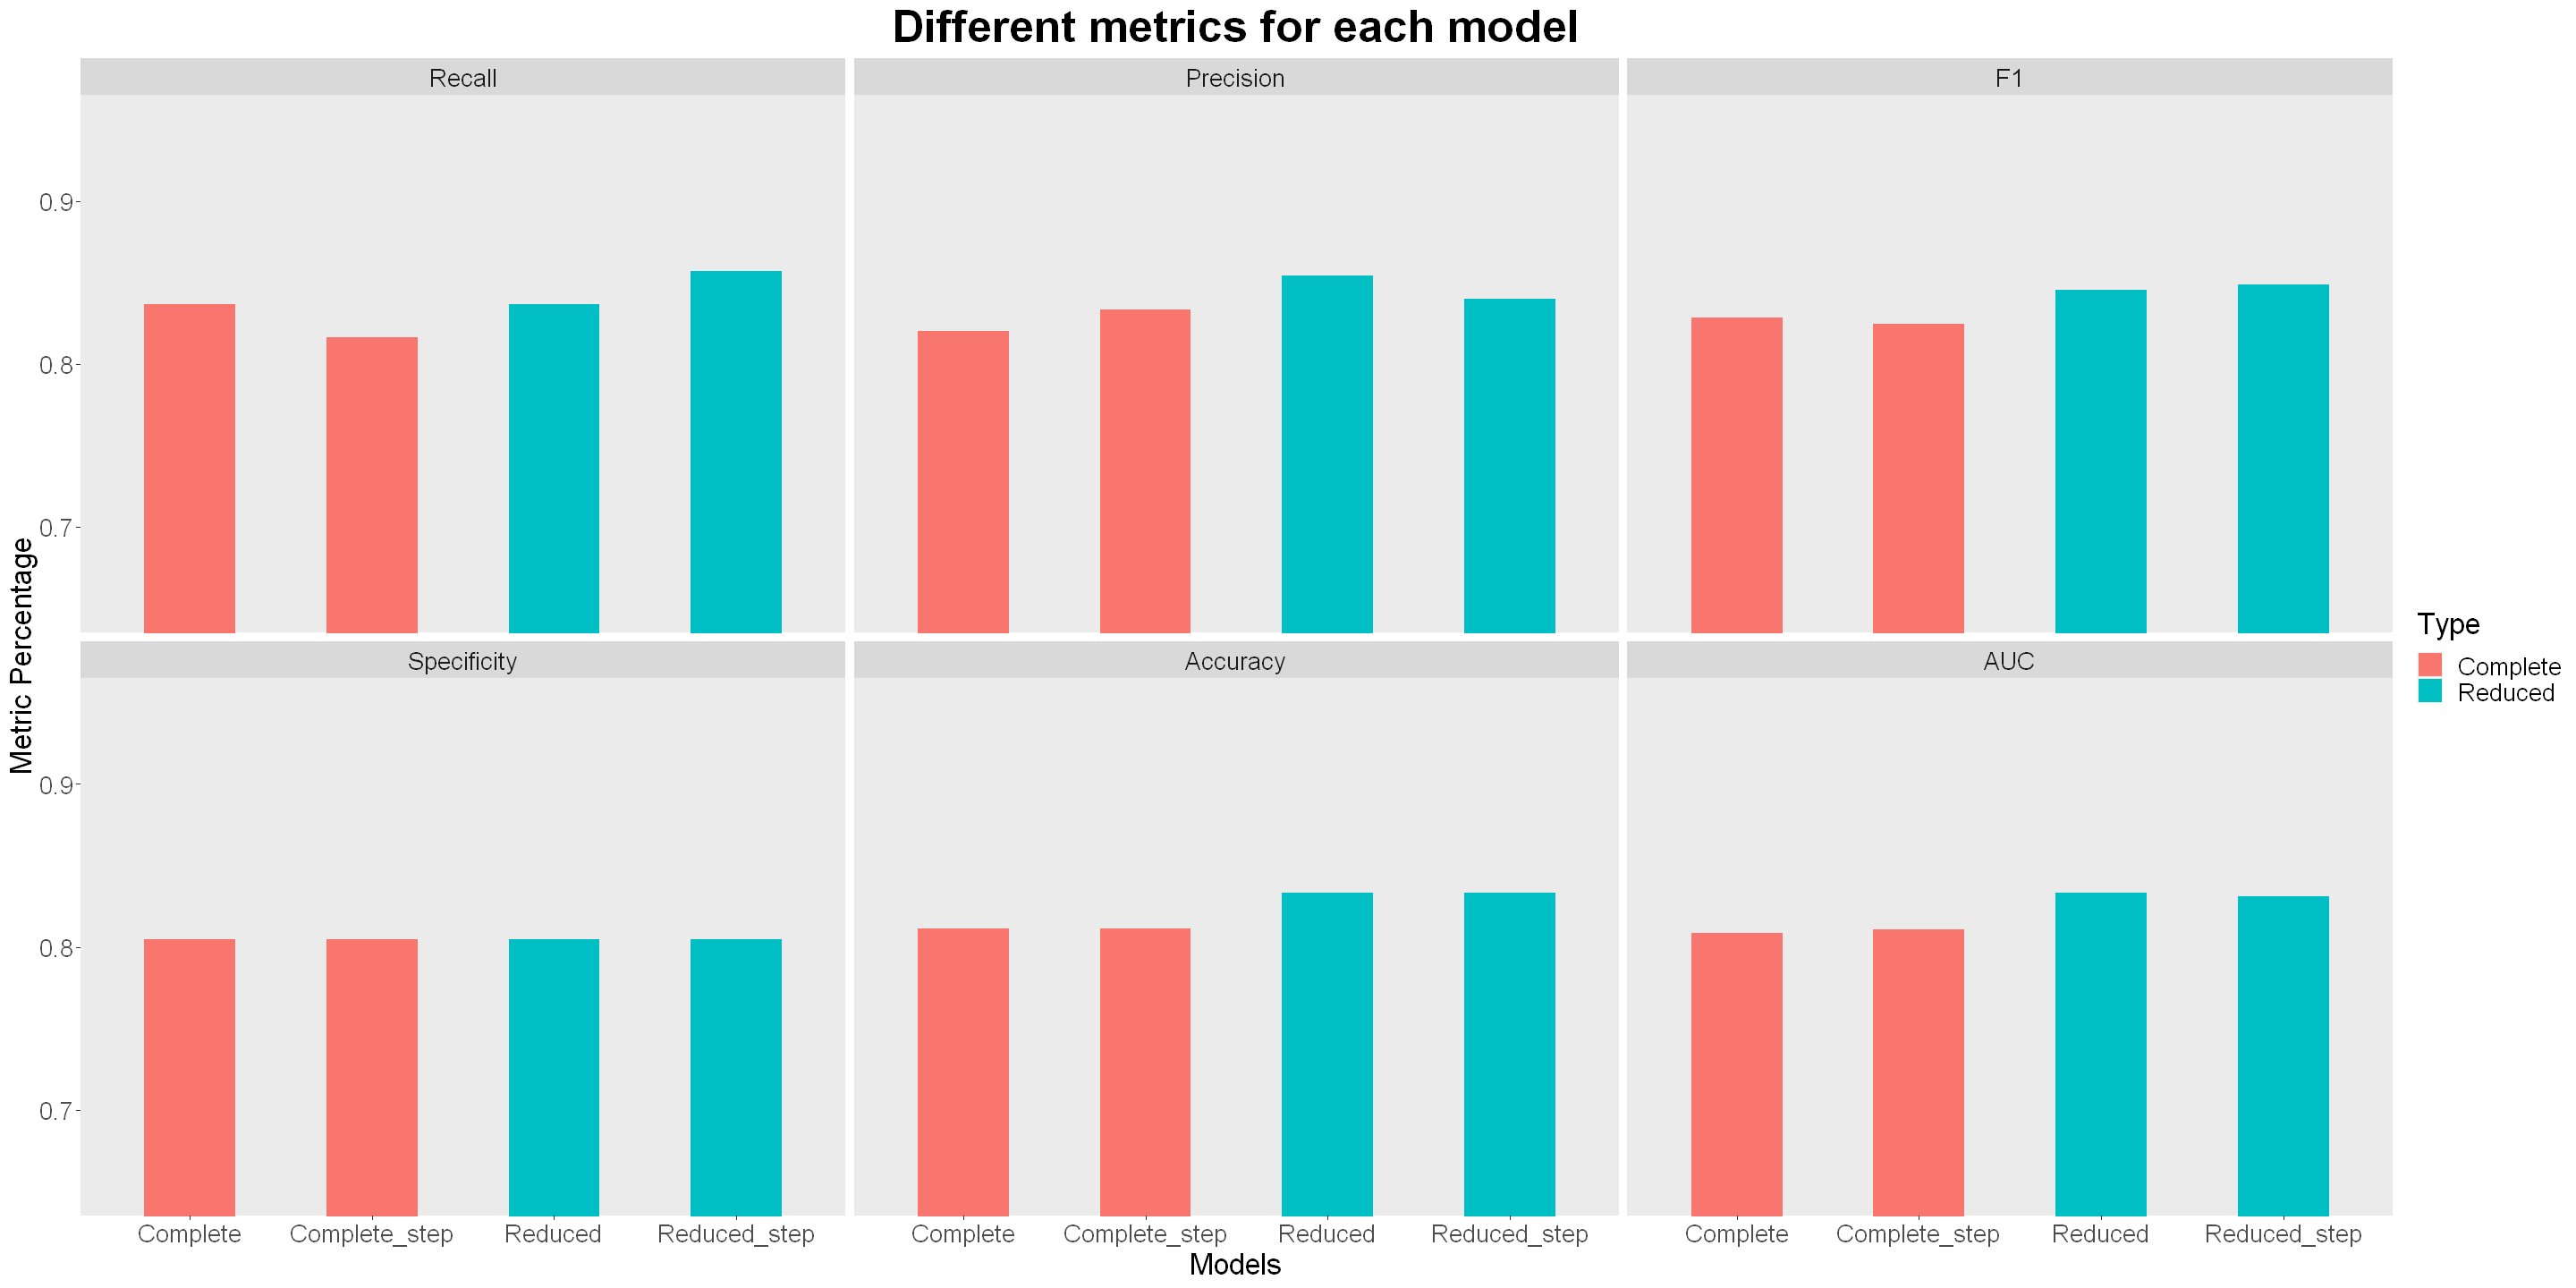

In [7]:
models.comp = list(glm.complete.fit, glm.completestep.fit)
models.red = list(glm.reduced.fit, glm.reducedstep.fit)

metrics = evaluate_models(models.comp, models.red, predict_function = make_preds)

There are **three** main conclusion that we can infer from the metrics displayed in the graph above, in regard to the **Logistic Regression** model:
* The model as a **high recall**, which means that most positive cases are predicted correctly, since this is a medical dataset this high recall is very important.
* There is a clear pattern for every metric, the **reduced dataset** (dataset created using **feature selection**) constantly obtains **better results than the complete model**.
* The models created using **stepwise selection** yields the **same or worse results** for most metrics, meaning that the **lasso is a more effective method** of reducing models than the stepwise selection.

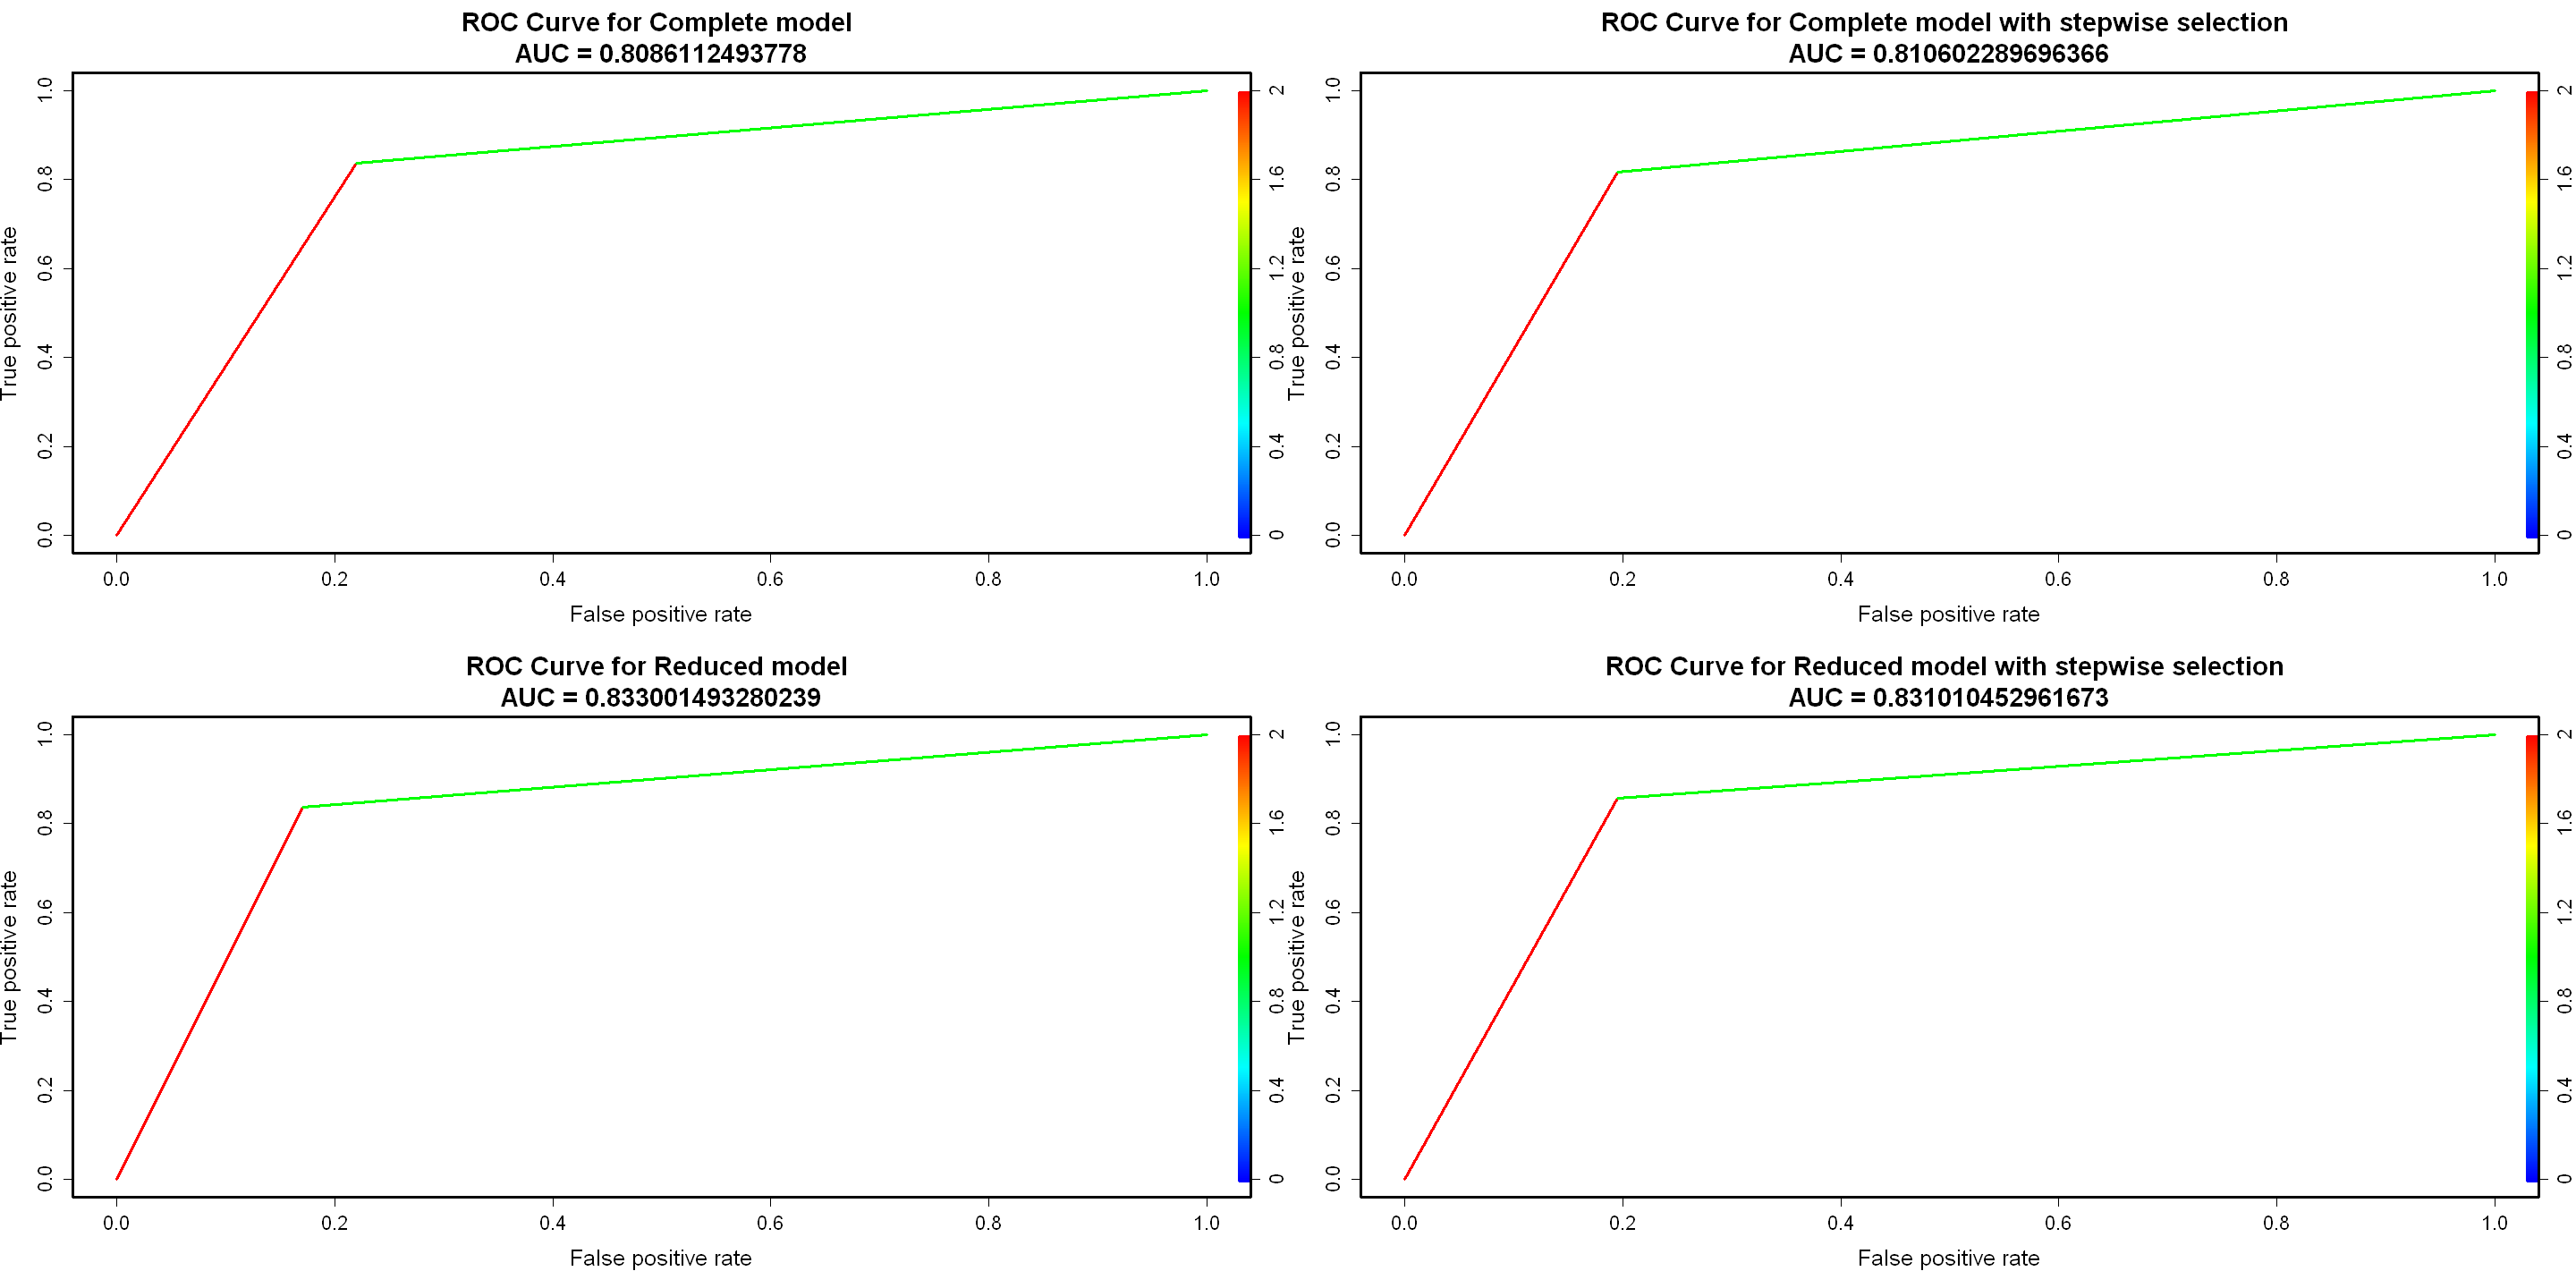

In [8]:
plot_ROCCurve(models.comp, models.red, predict_function = make_preds, x.models = c("Complete model", "Complete model with stepwise selection", "Reduced model", "Reduced model with stepwise selection"))

The ROC curve lines are very straight in this case, because the testing target variable is **ordered** (unintentionally), meaning that the "1s" show first and the "0s" come after.

Given these **AUCs** that are **higher than 80%**, we can see that the model has an 80% chance to able to distinguish between the positive and negative classes.

If the **threshold** that indicates if a class is classified as positive or negative (currently **0.5**) is **decreased**, then the probabily of predicting a value as positive will increase, i.e. the **sensitivity increases** while the **specifity decreases**, which in this case can be worth, since **predicting the positive class correctly is more important than predicting the negative class correctly**.

# Linear Discriminant Analysis (LDA)

Much like the Logistic Regression algorithm, the LDA focuses on estimating the **conditional probability** of the target variable based on the predictors. However, unlike the logistic regression, LDA models the distribution of each predictor for each target variable, applying after this the bayes theorem to estimate $Pr(Y = k|X = x)$, being X the predictors and Y the targets. [Reference ISLR, pg. 138]

There are a few **advantages** of using LDA instead of Logistic Regression:
* Logistic Regression can be unstable for well-seperated classes, unlike the LDA.
* LDA is better when the **number of observations is small** and the predictors distributions tends to be **normal**. (Could be a huge advantage in this problem, since we have a small dataset)
* LDA is more popular when the problem has **more than two target variables**. (Not the case in this problem) [Reference ISLR, pg. 138]

## Complete model

In [9]:
ret = train_test_split(uci_heart, train_size = 0.7); train.complete = ret$train; test.complete = ret$test
ret = train_test_split(df.reduced, train_size = 0.7); train.reduced = ret$train; test.reduced = ret$test

lda.complete.fit = lda(target ~ ., data = train.complete)
lda.complete.fit

Call:
lda(target ~ ., data = train.complete)

Prior probabilities of groups:
        0         1 
0.4549763 0.5450237 

Group means:
       age      sex0        cp3       cp2       cp0 trestbps     chol      fbs0
0 56.04167 0.1458333 0.06250000 0.1354167 0.7291667 132.3854 255.5521 0.8854167
1 52.08696 0.4347826 0.07826087 0.4521739 0.2695652 128.8609 240.3826 0.8695652
   restecg1   restecg2  thalach    exang1   oldpeak    slope2    slope1
0 0.3854167 0.02083333 137.8646 0.5520833 1.5614583 0.2604167 0.6562500
1 0.6086957 0.00000000 159.9739 0.1565217 0.5721739 0.6521739 0.2956522
         ca2       ca1       ca3        ca4     thal2     thal3
0 0.20833333 0.3229167 0.1145833 0.01041667 0.2291667 0.6666667
1 0.05217391 0.1217391 0.0173913 0.02608696 0.8173913 0.1391304

Coefficients of linear discriminants:
                  LD1
age       0.011528071
sex0      0.616469094
cp3       0.095515576
cp2       0.346678443
cp0      -0.371411867
trestbps -0.011635590
chol     -0.002725002
fbs0

Not much can be said from just looking at the model, but we can see that 46% of the dataset constains negative cases and 54% contains positive cases.

Another property of the LDA model is that, given the predictors X, the prediction is computed as such $0.012 * X1 + 0.643 * X2 + ...$, if the result is large the case is positive, otherwise it is negative. [reference ISLR, pg. 161, 162]

## Reduced model

In [10]:
lda.reduced.fit = lda(target ~ ., data = train.reduced)
lda.reduced.fit

Call:
lda(target ~ ., data = train.reduced)

Prior probabilities of groups:
        0         1 
0.4549763 0.5450237 

Group means:
       age      sex0  thalach    exang1   oldpeak      cp_11     cp_01
0 56.04167 0.1458333 137.8646 0.5520833 1.5614583 0.07291667 0.7291667
1 52.08696 0.4347826 159.9739 0.1565217 0.5721739 0.20000000 0.2695652
     fbs_11 restecg_01 restecg_11   slope_01  slope_11     ca_01     ca_11
0 0.1145833  0.5937500  0.3854167 0.08333333 0.6562500 0.3437500 0.3229167
1 0.1304348  0.3913043  0.6086957 0.05217391 0.2956522 0.7826087 0.1217391
     thal_11   thal_21
0 0.10416667 0.2291667
1 0.04347826 0.8173913

Coefficients of linear discriminants:
                    LD1
age        -0.001191235
sex0        0.511762413
thalach     0.013613478
exang1     -0.261125287
oldpeak    -0.182775208
cp_11      -0.302044761
cp_01      -0.654736168
fbs_11      0.261516279
restecg_01  0.137220308
restecg_11  0.443903183
slope_01   -0.308293705
slope_11   -0.362647550
ca_01     

For now, it is possible to see that the linear discriminant coefficients have altered slightly, due to the reduction made by feature selection.

## Comparison and conclusion

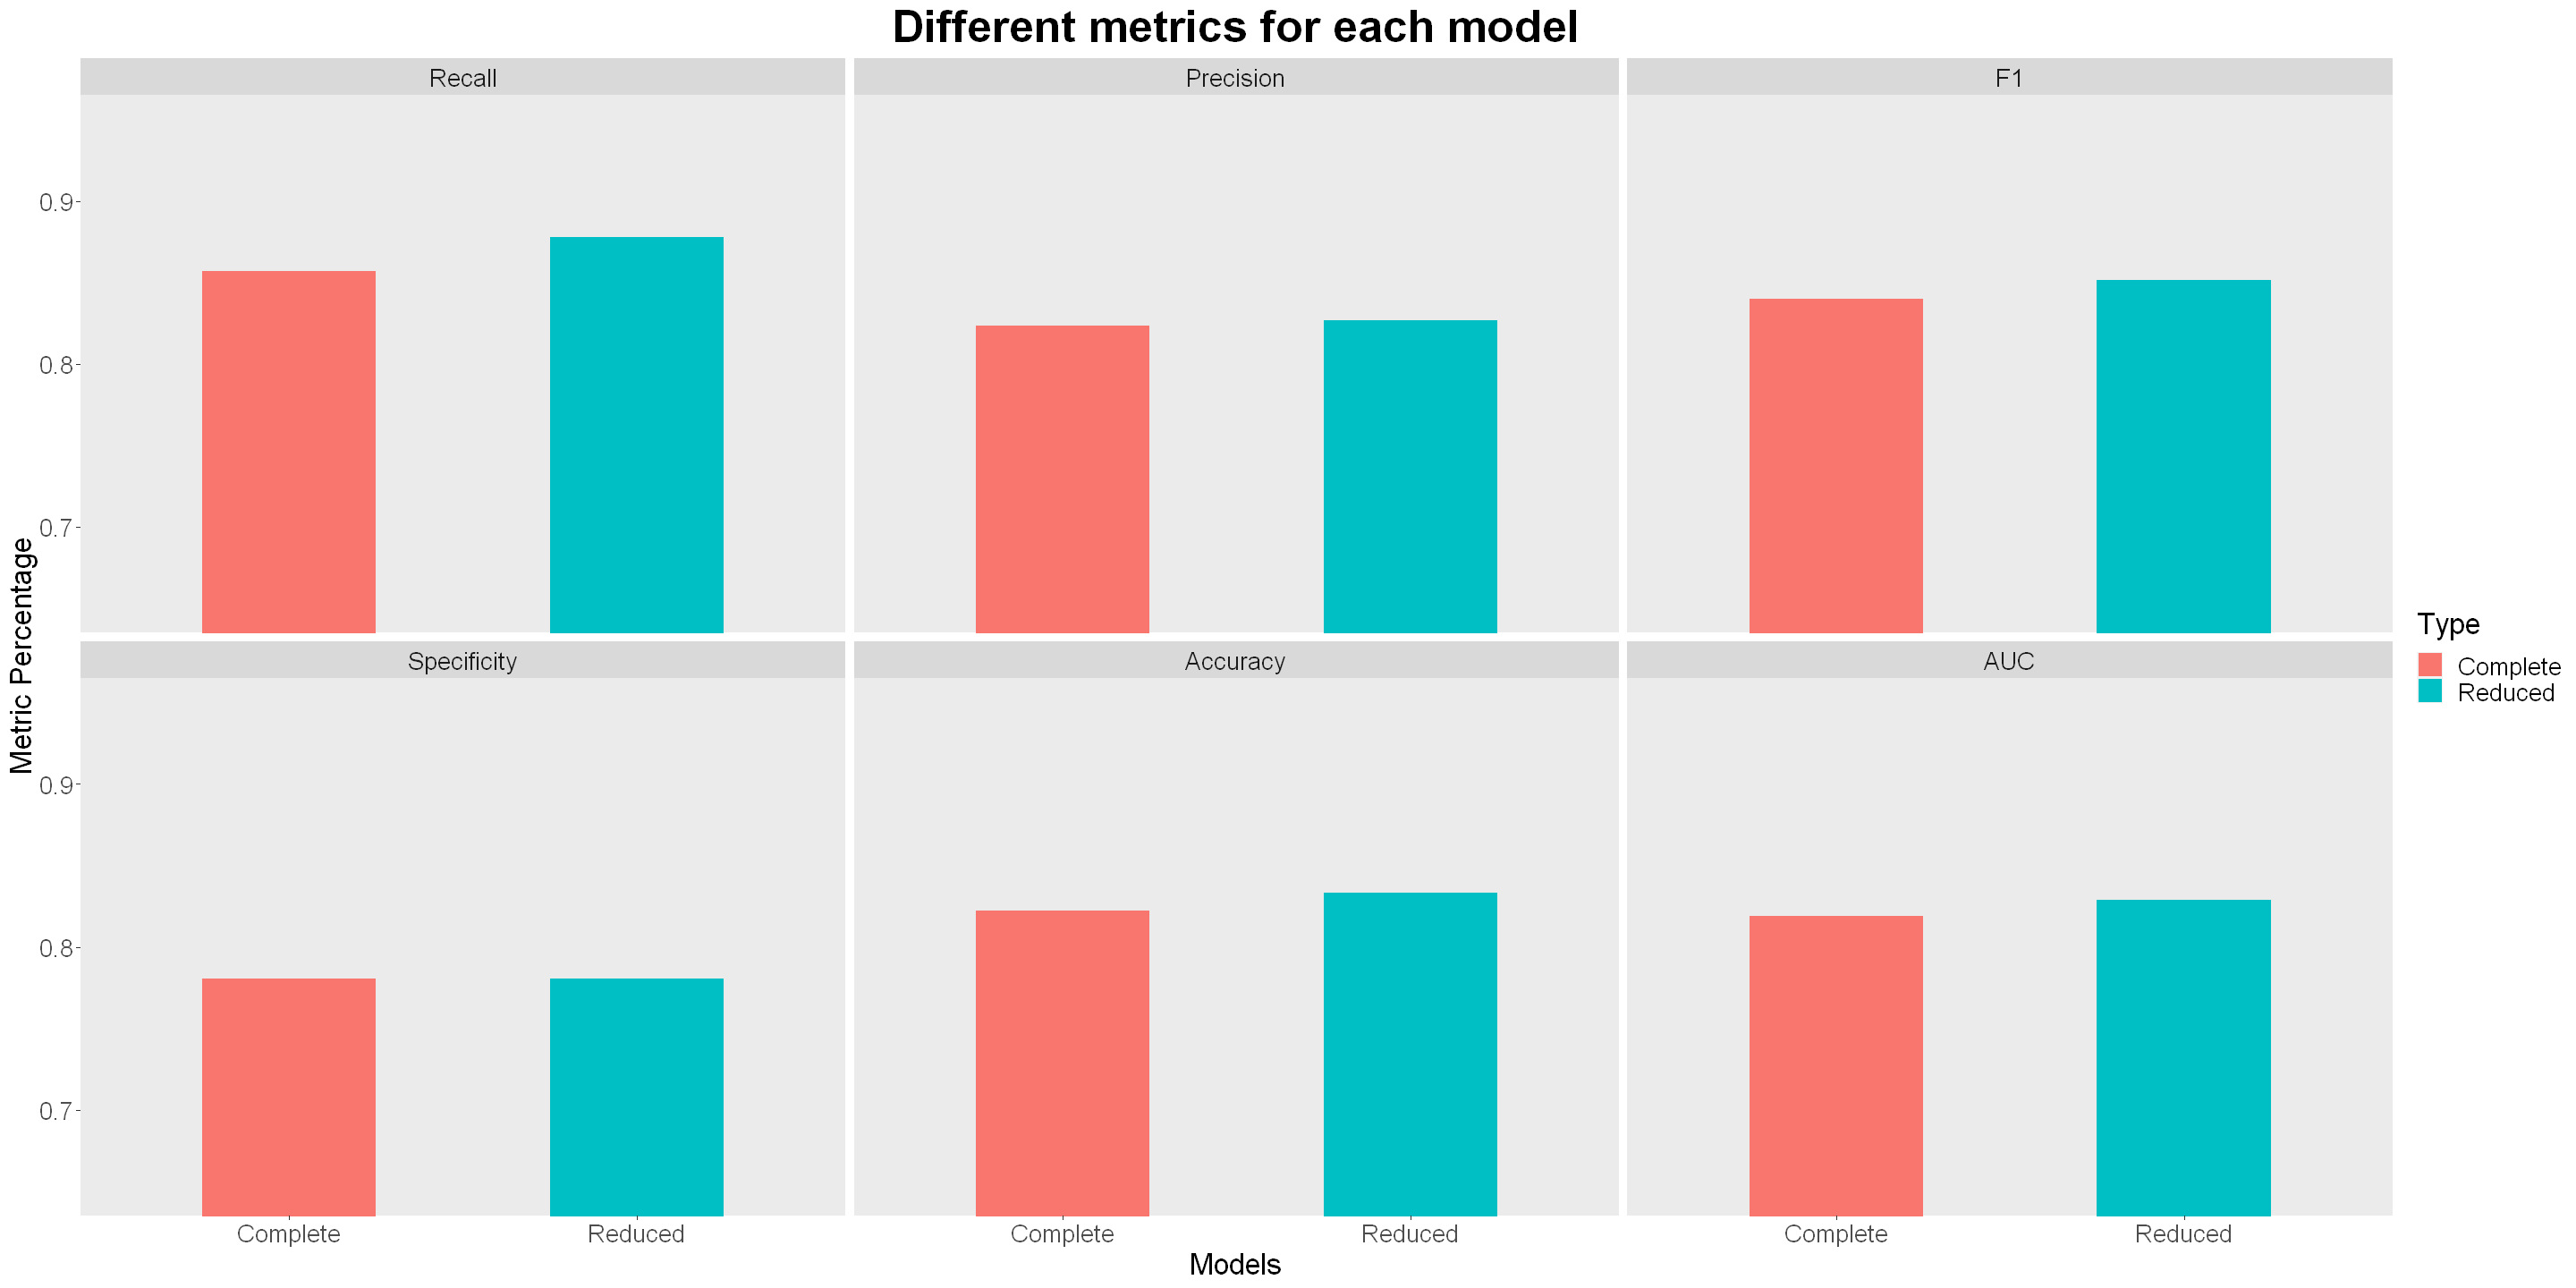

In [11]:
models.comp = list(lda.complete.fit)
models.red = list(lda.reduced.fit)

metrics = evaluate_models(models.comp, models.red, predict_function = lda_preds, x.models = c("Complete", "Reduced"))

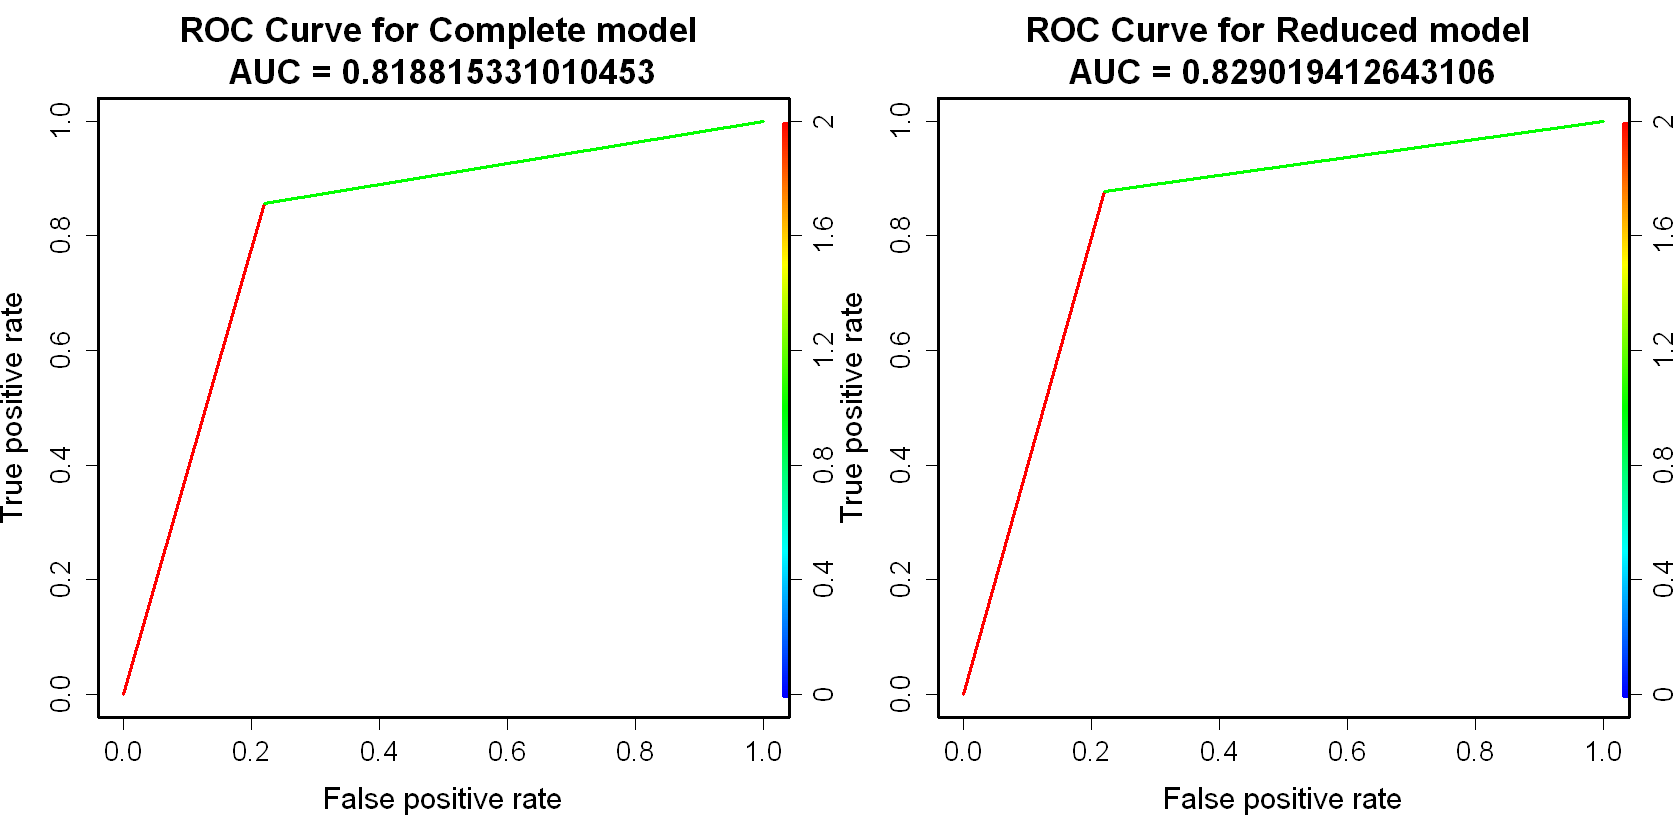

In [12]:
plot_ROCCurve(models.comp, models.red, predict_function = lda_preds, x.models = c("Complete model", "Reduced model"), plots.display = c(1,2), plot.width = 14, plot.height = 7)

In [13]:
#Help functions
to_numeric = function(x) {
    return(as.numeric(as.character(x)))
}
#Splits dataset into a train and test set with given percent split
train_test_split = function(data, train_size = 0.7) {
    #set.seed(123456789)
    set.seed(1)
    
    train_idx = createDataPartition(data$target, p = train_size, list = FALSE, times = 1)
    #train_idx = sample(1:nrow(data), train_size*nrow(data))
    
    tr = data[train_idx, ]
    te = data[-train_idx, ]
    
    return(list("train" = tr, "test" = te))
}

#Make prediction for a model and calculate its accuracy based on the test set
make_preds = function(model, data.test, threshold = 0.5) {
    glm.probs = predict(model, data.test, type = "response")
    glm.preds = ifelse(glm.probs > threshold, 1, 0)
    
    return(factor(glm.preds)) #deixa de ser preciso o y.test
}

#Predict for the lda model
lda_preds = function(model, x.test) {
    lda.pred = predict(model, x.test)
    return(lda.pred$class)
}

#Evaluate the various models passed as parameters, returns the metrics (Should be able to receive a function like "make_preds" for each type of model)
evaluate_models = function(models.complete, models.reduced, predict_function = make_preds, plot.width = 24, plot.height = 12, x.models = c("Complete", "Complete_step", "Reduced", "Reduced_step")) {
    
    #train test spliting for both types of datasets
    ret = train_test_split(uci_heart, train_size = 0.7); train.complete = ret$train; test.complete = ret$test
    ret = train_test_split(df.reduced, train_size = 0.7); train.reduced = ret$train ;test.reduced = ret$test
    #It is the same for both datasets
    y_train = train.reduced$target; y_test = test.reduced$target

    #Evaluate model and retrieve immportant metrics
    recalls = c(); precisions = c(); f1scores = c(); specificities = c(); accs = c(); AUCs = c(); type = c()

    i = 1
    for(model in models.complete){
        preds = predict_function(model, test.complete)
        confm = caret::confusionMatrix(preds, y_test, positive = "1")
        recalls[i] = confm$byClass["Recall"]; precisions[i] = confm$byClass["Precision"]; f1scores[i] = confm$byClass["F1"]; specificities = confm$byClass["Specificity"]; accs[i] = confm$overall["Accuracy"];
        AUCs[i] = calc_AUC(preds, y_test)$auc
        type[i] = "Complete"

        i = i + 1
    }

    for(model in models.reduced) {
        preds = predict_function(model, test.reduced)
        confm = caret::confusionMatrix(preds, y_test, positive = "1")
        recalls[i] = confm$byClass["Recall"]; precisions[i] = confm$byClass["Precision"]; f1scores[i] = confm$byClass["F1"]; specificities = confm$byClass["Specificity"]; accs[i] = confm$overall["Accuracy"];
        AUCs[i] = calc_AUC(preds, y_test)$auc
        type[i] = "Reduced"

        i = i + 1
    }

    metrics = data.frame(Recall = recalls, Precision = precisions, F1 = f1scores, Specificity = specificities, Accuracy = accs, AUC = AUCs, Type = type, Models = x.models, row.names = NULL)
    
    #visualization
    print(visualize_metrics(metrics, plot.width, plot.height))
    
    return(metrics)
}

#Method to Visualize all the metrics of a model, the metrics dataframe must have the structure [Metrics, Model Type, Model Name]
visualize_metrics = function(metrics, plot.width = 24, plot.height = 12) {
    options(repr.plot.width = plot.width, repr.plot.height = plot.height)
    #melt for facet wrap
    metrics.melt = melt(metrics, id.vars = c("Models", "Type"), value.name = "Count", variable.name = "Variable")

    p = ggplot(data = metrics.melt) + 
            geom_bar(aes(x = Models, y = Count, fill = Type), stat = "identity", width = 0.5) + facet_wrap("Variable") +
            scale_y_continuous(limits = c(0.65, 0.95), oob=rescale_none) + 
            labs(title = "Different metrics for each model", y = "Metric Percentage") +
            theme(text = element_text(size = 20), plot.title = element_text(size = 30, face = "bold", hjust = 0.5), panel.grid.minor = element_blank(), panel.grid.major = element_blank())
    
    return(p)
}

#Plots the ROC Curve of all the models in the parameters "models.complete" and "models.reduced". 
#"x.models" must have the same size as the number of models passed.
plot_ROCCurve = function(models.complete, models.reduced, predict_function = make_preds, x.models = c("Complete", "Complete_step", "Reduced", "Reduced_step"), plots.display = c(2,2), plot.width = 24, plot.height = 12) {
    options(repr.plot.width = plot.width, repr.plot.height = plot.height)
    par(cex.main = 1.75, cex.axis = 1.35, cex.lab = 1.5, lwd = 2.5, mfrow = plots.display)
    
    #train test spliting for both types of datasets
    ret = train_test_split(uci_heart, train_size = 0.7); train.complete = ret$train; test.complete = ret$test
    ret = train_test_split(df.reduced, train_size = 0.7); train.reduced = ret$train ;test.reduced = ret$test
    #It is the same for both datasets
    y_train = train.reduced$target; y_test = test.reduced$target
    
    i = 1
    for(model in models.complete) {
        ret = calc_AUC(predict_function(model, test.complete), y_test)
        
        perf <- performance(ret$pred,"tpr","fpr")
        plot(perf, colorize = TRUE, main = paste("ROC Curve for", x.models[i], "\nAUC =", ret$auc))
        i = i + 1
    }
    
    for(model in models.reduced) {
        ret = calc_AUC(predict_function(model, test.reduced), y_test)
        
        perf <- performance(ret$pred,"tpr","fpr")
        plot(perf, colorize = TRUE, main = paste("ROC Curve for", x.models[i], "\nAUC =", ret$auc))

        i = i + 1
    }
}

#Calculate the AUC using the ROCR package
calc_AUC = function(y.pred, y.test) {
    pred <- prediction(to_numeric(y.pred), y.test)
    auc.tmp = performance(pred, "auc")
    return(list("auc" = as.numeric(auc.tmp@y.values), "pred" = pred))
}